# Análise de sentimentos de tweets brasileiros nos períodos anterior e inicial da pandemia de Covid-19
***

<img style="float: left;" src="images/menu_resultados.png" width="800" height="500">

## IV - Análise dos resultados

Esta etapa apresentará uma **análise dos resultados obtidos** a partir dos **sentimentos de *tweets*** processados pela ferramenta VADER (1), realizados no passo anterior deste trabalho.

A partir de uma **base de dados de casos de Covid-19**, construída a partir dos **boletins das Secretarias Estaduais de Saúde(SES)** (2), foram calculados intervalos referentes aos **períodos anterior e inicial da pandemia de Covid-19 no Brasil**. Estes intervalos, então, ficaram divididos em **3 períodos**: **antes do primeiro caso de Covid-19**; **após o primeiro caso de Covid-19**; e **após a primeira morte por Covid-19**, para cada cidade selecionada.

Em seguida, após filtragens realizadas em relação ao intervalo mínimo para cada período, serão criados conjuntos contendo cidades com **menores médias *scores* de sentimentos** e **maiores médias de *scores* de sentimentos**. Os limites numéricos para a construção destes conjuntos foram extraídos de métricas estatísticas sobre os resultados dos *scores*.

Por fim, serão gerados gráficos com a finalidade de observar **padrões comportamentais dos usuários** do Twitter, a partir das **análise de sentimentos** calculadas nos **3 períodos analisados**.

***
### Importações gerais

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import re
import numpy as np

from datetime import datetime
from datetime import timedelta

from statistics import mean

import warnings
warnings.filterwarnings('ignore')

### Configurações Iniciais

#### Conexão ao banco de dados

In [2]:
# Criando estrutura do banco de dados
from pymongo import MongoClient

# Conexão com o servidor do MongoDB
client = MongoClient('localhost', 27017)

# Conexão com a base de dados do mongoDB
db = client.SpedDB

# Coleção onde serão inseridos os dados
collection = db.tweets_brasil

#### Definição de variáveis

Nas células abaixo são definidas variáveis utilizadas no procedimento de análises de resultados.

A variável referente às *hashtags* armazena *strings* a serem desconsideradas nos gráficos de gerações de palavras, por serem palavras comuns ao universo dos registros presentes na base de dados (são, em maioria, *hashtags* utilizadas pelo GeoCoV19 para a coleta de *tweets*).

In [3]:
# Hashtags que serão desconsideradas nos items de processamentos de palavras pois são hashtags base que foram utilizados pelo GeoCov19 para seleção de todos os tweets (se repetem em todos os tweets)
default_hashtags = ['#coronavírus','#covid19','#covid2019','#covid19brasil','#covid2019brasil','#covid','#corona','#coronavirusbrasil', '#coronavirusnobrasil', '#coronavirus', '#covid-19', '#covidー19', '#covid_19', '#novocoronavírus']

# Número mínimo de dias por período analisado
min_num_days = 3

# Cores
back_color_default = 'slategray'
back_color_dados_neg = 'indianred'
back_color_dados_pos = 'steelblue'

***
### Retornado resultados de tweets selecionados

Nos itens a seguir, é realizado o **carregamento dos registros com sentimentos processados** pelo VADER. Estes dados são carregados em um *dataframe*.

In [4]:
df = pd.DataFrame.from_records(collection.find({'lang': 'pt', 'score': {'$ne':None}, '$or':[{'geo_source':'place'}, {'geo_source':'user_location'}]}, {'state':1,'city':1,'lang':1,'geo_source':1,'score':1,'created_at':1,'text':1,'_id': 0}).sort('created_at'))

In [5]:
df.head()

,created_at,geo_source,state,city,text,score,lang
0,2020-02-02 09:32:32,user_location,Piauí,Amarante,RT @FuturasPromess: RTT ou amanhã acordas com ...,-0.3400,pt
1,2020-02-02 09:33:28,user_location,São Paulo,Sorocaba,RT @revistasuper: #SuperLidas A doença surgiu ...,0.0000,pt
2,2020-02-02 09:34:20,user_location,Piauí,Amarante,RT @FuturasPromess: RTT ou amanhã acordas com ...,-0.3400,pt
3,2020-02-02 09:38:24,user_location,Paraíba,João Pessoa,RT @lelispatricia: Olavo de Carvalho é o “guru...,-0.4767,pt
4,2020-02-02 09:39:50,user_location,São Paulo,Conchas,RT @da_goiabeira: Passam a vida criticando a c...,-0.3612,pt


***
### Quantitativos de dados a serem analisados

Nos item a seguir são apresentadas totalizações da base de registros que serão analisados e quantitativos por localizações (cidades e estados).

#### Quantidade total de tweets carregados

In [6]:
len(df)

1219385

**Quantidade total de cidades analisadas**

In [7]:
len(df.city.value_counts())

2886

#### Quantidade de *tweets* por estado

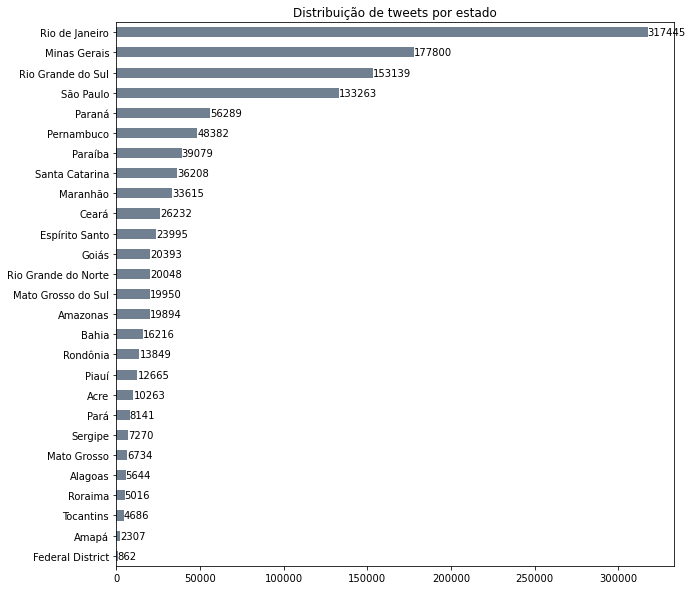

In [8]:
# Distribuição de tweets por estado
df.state.value_counts().sort_values().plot(kind='barh', figsize=(10, 10), title='Distribuição de tweets por estado', color=back_color_default)

for index, value in enumerate(df.state.value_counts().sort_values()):
    plt.text(value, index, str(value), verticalalignment='center')

#### Quantidade de *tweets* por cidade

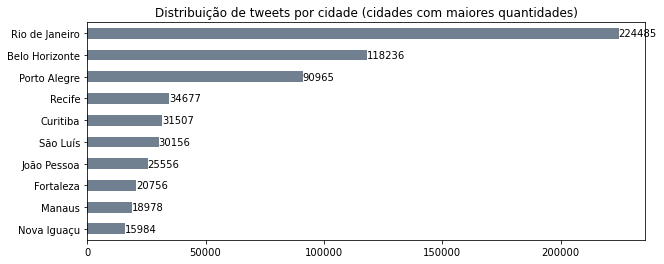

In [9]:
df_city = df.city.value_counts()[:10]

df_city.sort_values().plot(kind='barh', figsize=(10, 4), title='Distribuição de tweets por cidade (cidades com maiores quantidades)', color=back_color_default)

for index, value in enumerate(df_city.sort_values()):
    plt.text(value, index, str(value), verticalalignment='center')

***
### Processamento das análises de sentimentos por períodos

Neste ponto, serão iniciados os processamentos que fornecerão os **insumos** para a realização das **análises dos resultados dos sentimentos dos *tweets* nos 3 períodos analisados** (antes do primeiro caso, após o primeiro caso e após a primeia morte), para cada cidade.

#### Funções auxiliares para processamento de textos

As funções abaixo implementam procedimentos para processamento de textos que fornecerão saídas para as gerações de gráficos envolvendo a ocorrência de palavras em um dado conjunto de *tweets*.

A biblioteca ***NLTK*** foi utilizada para a realização de tarefas como tokenização e remoção de *stopwords*.

In [10]:
import nltk
import collections

from nltk.tokenize import TweetTokenizer
from string import punctuation
from wordcloud import WordCloud, STOPWORDS

from datetime import datetime
from datetime import timedelta

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/mario/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#### Calculando datas de início e fim dos períodos

Nos itens a seguir são calculadas as datas de **primeiro caso de Covid-19** e **primeira morte por Covid-19** para cada cidade. Estas datas serão utilizadas para a definição das datas de início e fim dos **3 períodos a serem analisados** (antes da primeiro caso, após o primeiro caso e após a primeira morte) para cada cidade, posteriormente.

Estas datas são **calculadas automaticamente** com a utilização de uma base de dados construída a partir dos **boletins das Secretarias Estaduais de Saúde(SES)**. Esta base possui informações de casos confirmados e óbitos, por data, para cada município (2).

Durante o cálculo de datas de início e fim de cada período, são **filtradas as cidades que possuem períodos de no mínimo 3 dias**, para minimizar o impacto de períodos muito curtos no cálculo da média de sentimentos por períodos.

O item a seguir **carrega o banco de dados com casos de Covid-19** a partir de um arquivo *CSV*:

In [11]:
# Carregando arquivo CSV contendo casos de Covid-19 do Brasil
file = '/home/mario/Documentos/LCDIA/Analytics/Datasets/caso_full.csv'
df_cases_brasil = pd.read_csv(file, usecols=['city', 'state', 'date', 'new_confirmed', 'new_deaths','last_available_confirmed','last_available_deaths','last_available_confirmed_per_100k_inhabitants','last_available_death_rate'])

In [12]:
df_cases_brasil.columns

Index(['city', 'date', 'last_available_confirmed',
       'last_available_confirmed_per_100k_inhabitants',
       'last_available_death_rate', 'last_available_deaths', 'state',
       'new_confirmed', 'new_deaths'],
      dtype='object')

No processamento abaixo ocorre o **cálculo das datas citadas** inicialmente para cada cidade.

In [13]:
def process_cases_cities_dates(df):
    
    cities = df.groupby(['city','state'])

    cities_cases_date = []
    initial = '2020-02-01'
    final = '2020-05-01'

    for item, state in cities['city','state']:

        city = item[0]
        state = item[1]

        df_cases_city = df_cases_brasil.query('city == "'+city+'"')
        df_cases_city = df_cases_city.reset_index()
        df_cases_city = df_cases_city.drop(columns=['index'])

        if (len(df_cases_city) > 0):

            # Data do primeiro caso 
            first_case = df_cases_city.loc[0, 'date']

            # Data da primeira morte
            result = df_cases_city.query('last_available_deaths != "0"')

            if (len(result) > 0):
                first_death = df_cases_city.loc[min(result.index), 'date']

                initial_date = datetime.strptime(initial, '%Y-%m-%d')
                first_case_date = datetime.strptime(first_case, '%Y-%m-%d')
                first_death_date = datetime.strptime(first_death, '%Y-%m-%d')
                final_date = datetime.strptime(final, '%Y-%m-%d')

                total_days1 = (first_case_date - initial_date).days
                total_days2 = (first_death_date - first_case_date).days
                total_days3 = (final_date - first_death_date).days

                if (total_days1 > min_num_days and total_days2 > min_num_days and total_days3 > min_num_days):
                    data = [city, state, first_case, first_death]
                    cities_cases_date.append(data)

    df_cities_cases_date = pd.DataFrame.from_dict(cities_cases_date)
    df_cities_cases_date.columns = ['city', 'state', 'first_case_date', 'first_death_date']
    
    return df_cities_cases_date

In [14]:
df_cities_cases_date = process_cases_cities_dates(df)

O *dataframe* a seguir exibe um recorte dos registros com as colunas criadas contendo as datas calculadas no processamento realizado acima:

In [15]:
df_cities_cases_date.head()

,city,state,first_case_date,first_death_date
0,Abreu e Lima,Pernambuco,2020-04-09,2020-04-22
1,Acopiara,Ceará,2020-04-13,2020-04-27
2,Afonso Cláudio,Espírito Santo,2020-04-01,2020-04-24
3,Agudos,São Paulo,2020-04-02,2020-04-08
4,Aliança,Pernambuco,2020-04-01,2020-04-16


Após este processamento, o ocorre uma **diminuição na quantidade de cidades analisadas**, por conta das filtragens realizadas, como mostrado no código abaixo:

In [16]:
len(df_cities_cases_date)

333

In [17]:
df_cities_cases_date.columns

Index(['city', 'state', 'first_case_date', 'first_death_date'], dtype='object')

#### Processamento de dados por período

No processamento realizado a seguir ocorre a **geração de dados provenientes das análises de sentimentos e dos conteúdos dos *tweets*** das cidades selecionadas até então. Estes dados são processados **para cada cidade e para cada um dos 3 períodos analisados** (antes do primeiro caso, após o primeiro caso e após a primeira morte).

Os intervalos de datas referentes aos períodos citados são detalhados abaixo:

- **Primeiro Período**: Iniciando em 01/02/2020 (data do primeiro registro da base de dados) à data anterior ao primeiro caso de Covid-19 na cidade;
- **Segundo Período**: Iniciando na data do primeiro caso de Covid-19 na cidade à data anterior à primeira morte por Covid-19;
- **Terceiro Período**: Iniciando na data da primeira morte por Covid-19 na cidade à 01/05/2020 (data do último registro da base de dados)

Para cada um desses períodos, são gerados os seguintes dados que servirão de insumos para as análises realizadas mais adiante neste trabalho:

- **Média de *score* de sentimento total**;
- **Média de *score* de sentimento por período**;
- **Quantidade total de *tweets***;
- **Quantidade total de *tweets* por período**;
- **100 palavras com maior ocorrência em frases que mais influenciaram negativamente os *scores* de sentimentos**;
- **100 palavras com maior ocorrência em frases que mais influenciaram positivamente os *scores* de sentimentos**;

Durante este procedimento, ocorre a filtragem onde são consideradas somentes cidades que possuam no mínimo a quantidade de 300 *tweets* por período. Esta seleção ajuda a minimizar o impacto no cálculo da média de sentimentos para períodos com poucas quantidade de *tweets*.

In [18]:
# Quantidade mínima de tweets aceitáveis para cada período
min_tweets = 100

# Quantidade máxima de tokens a serem retornadas para cada frase analisada
max_tokens = 100

In [19]:
def generate_tweets_tokens(texts):
        
    tokens = []
    
    hashtags_words = ['coronavíru','coronaviru','víru','viru','corona','coronavírus','coronavirus','virus','vírus','covid','covid19','covid-19', '19']
    words = ['’','“','','…','``','...','\'\'','t','https','http','co','rt','pra','pro','vc','pq','q','p','contra','tudo','sobre','aí','outro','tá','vai','ser','estar','está','to']
    stopwords = words + default_hashtags + hashtags_words + list(punctuation) + nltk.corpus.stopwords.words('portuguese')
    
    tweet_tokenizer = TweetTokenizer()
    
    for text in texts:        
        words = tweet_tokenizer.tokenize(text)
        for word in words:
            word.encode("ascii", errors="ignore").decode()      
            if word.lower() not in stopwords:
                tokens.append(word.lower())
   
    return tokens

In [20]:
def return_most_negative_tokens(df, end, max_tokens):
    
    top_words = []    
    df_query = df.loc[df['score'] < end]

    words = list(df_query['text'])
    tokens = generate_tweets_tokens(words)
    counter = collections.Counter(tokens)
    
    return dict(counter.most_common(max_tokens))

In [21]:
def return_most_positive_tokens(df, start, max_tokens):
    
    top_words = []    
    df_query = df.loc[df['score'] > start]

    words = list(df_query['text'])
    tokens = generate_tweets_tokens(words)
    counter = collections.Counter(tokens)
    
    return dict(counter.most_common(max_tokens))

In [22]:
def generate_cities_data(df, df_cities_cases_date, min_tweets, max_tokens):

    score_mean = []
    score_mean_1 = []
    score_mean_2 = []
    score_mean_3 = []

    qtd_tweets = []
    qtd_tweets_1 = []
    qtd_tweets_2 = []
    qtd_tweets_3 = []

    tokens_neg = []
    tokens_neg_1 = []
    tokens_neg_2 = []
    tokens_neg_3 = []

    tokens_pos = []
    tokens_pos_1 = []
    tokens_pos_2 = []
    tokens_pos_3 = []

    total_processed = 0

    for index, row in df_cities_cases_date.iterrows():

        city = row['city']
        first_case = row['first_case_date']
        first_death = row['first_death_date']

        total_processed = total_processed + 1

        df_tweets = df.query('city == "'+city+'"')
        df_tweets_1 = df_tweets.query('created_at >= "2020-02-01 00:00:00" and created_at < "'+first_case+' 00:00:00"')  
        df_tweets_2 = df_tweets.query('created_at >= "'+first_case+' 00:00:00" and created_at < "'+first_death+' 00:00:00"')
        df_tweets_3 = df_tweets.query('created_at >= "'+first_death+' 00:00:00" and created_at < "2020-05-02 00:00:00"')

        if (len(df_tweets_1) >= min_tweets and len(df_tweets_2) >= min_tweets and len(df_tweets_3) >= min_tweets):

            score_mean.append(mean(df_tweets['score']))        
            score_mean_1.append(mean(df_tweets_1['score']))
            score_mean_2.append(mean(df_tweets_2['score']))
            score_mean_3.append(mean(df_tweets_3['score']))

            end = df_tweets['score'].describe()['25%']

            tokens_city_neg = return_most_negative_tokens(df_tweets, end, max_tokens)
            tokens_city_neg_1 = return_most_negative_tokens(df_tweets_1, end, max_tokens)
            tokens_city_neg_2 = return_most_negative_tokens(df_tweets_2, end, max_tokens)
            tokens_city_neg_3 = return_most_negative_tokens(df_tweets_3, end, max_tokens)

            tokens_neg.append(tokens_city_neg)
            tokens_neg_1.append(tokens_city_neg_1)
            tokens_neg_2.append(tokens_city_neg_2)
            tokens_neg_3.append(tokens_city_neg_3)

            start = df_tweets['score'].describe()['75%']

            tokens_city_pos = return_most_positive_tokens(df_tweets, start, max_tokens)
            tokens_city_pos_1 = return_most_positive_tokens(df_tweets_1, start, max_tokens)
            tokens_city_pos_2 = return_most_positive_tokens(df_tweets_2, start, max_tokens)
            tokens_city_pos_3 = return_most_positive_tokens(df_tweets_3, start, max_tokens)

            tokens_pos.append(tokens_city_pos)
            tokens_pos_1.append(tokens_city_pos_1)
            tokens_pos_2.append(tokens_city_pos_2)
            tokens_pos_3.append(tokens_city_pos_3)

            qtd_tweets.append(len(df_tweets))
            qtd_tweets_1.append(len(df_tweets_1))
            qtd_tweets_2.append(len(df_tweets_2))
            qtd_tweets_3.append(len(df_tweets_3))

        else:
            df_cities_cases_date = df_cities_cases_date.drop(index)

        print(total_processed,'processado(s)')

    df_cities_cases_date['score_mean'] = score_mean
    df_cities_cases_date['score_mean_1'] = score_mean_1
    df_cities_cases_date['score_mean_2'] = score_mean_2
    df_cities_cases_date['score_mean_3'] = score_mean_3

    df_cities_cases_date['tokens_neg'] = tokens_neg
    df_cities_cases_date['tokens_neg_1'] = tokens_neg_1
    df_cities_cases_date['tokens_neg_2'] = tokens_neg_2
    df_cities_cases_date['tokens_neg_3'] = tokens_neg_3

    df_cities_cases_date['tokens_pos'] = tokens_pos
    df_cities_cases_date['tokens_pos_1'] = tokens_pos_1
    df_cities_cases_date['tokens_pos_2'] = tokens_pos_2
    df_cities_cases_date['tokens_pos_3'] = tokens_pos_3

    df_cities_cases_date['qtd_tweets'] = qtd_tweets
    df_cities_cases_date['qtd_tweets_1'] = qtd_tweets_1
    df_cities_cases_date['qtd_tweets_2'] = qtd_tweets_2
    df_cities_cases_date['qtd_tweets_3'] = qtd_tweets_3
    
    return df_cities_cases_date

In [23]:
df_cities_cases_date = generate_cities_data(df, df_cities_cases_date, min_tweets, max_tokens)

1 processado(s)
2 processado(s)
3 processado(s)
4 processado(s)
5 processado(s)
6 processado(s)
7 processado(s)
8 processado(s)
9 processado(s)
10 processado(s)
11 processado(s)
12 processado(s)
13 processado(s)
14 processado(s)
15 processado(s)
16 processado(s)
17 processado(s)
18 processado(s)
19 processado(s)
20 processado(s)
21 processado(s)
22 processado(s)
23 processado(s)
24 processado(s)
25 processado(s)
26 processado(s)
27 processado(s)
28 processado(s)
29 processado(s)
30 processado(s)
31 processado(s)
32 processado(s)
33 processado(s)
34 processado(s)
35 processado(s)
36 processado(s)
37 processado(s)
38 processado(s)
39 processado(s)
40 processado(s)
41 processado(s)
42 processado(s)
43 processado(s)
44 processado(s)
45 processado(s)
46 processado(s)
47 processado(s)
48 processado(s)
49 processado(s)
50 processado(s)
51 processado(s)
52 processado(s)
53 processado(s)
54 processado(s)
55 processado(s)
56 processado(s)
57 processado(s)
58 processado(s)
59 processado(s)
60 pro

Recorte do *dataframe* contendo os dados gerados para cada cidade e cada período realizados acima:

In [24]:
df_cities_cases_date.head()

,city,state,first_case_date,first_death_date,score_mean,score_mean_1,score_mean_2,score_mean_3,tokens_neg,tokens_neg_1,tokens_neg_2,tokens_neg_3,tokens_pos,tokens_pos_1,tokens_pos_2,tokens_pos_3,qtd_tweets,qtd_tweets_1,qtd_tweets_2,qtd_tweets_3
5,Alvorada,Rio Grande do Sul,2020-03-19,2020-04-08,-0.067740,-0.034808,-0.047727,-0.097979,"{'brasil': 10, 'pessoas': 10, 'morrer': 9, '😭'...","{'mundo': 5, 'ta': 4, 'todo': 4, 'olha': 3, 'm...","{'casa': 6, 'agora': 5, 'matar': 5, 'caso': 4,...","{'@correio_dopovo': 7, 'primeira': 7, 'saúde':...","{'agora': 14, 'casa': 11, 'fazer': 10, 'bolson...","{'tão': 6, 'amigos': 5, 'ninguém': 4, '🤣': 4, ...","{'agora': 8, 'casa': 8, 'ai': 5, '😑': 4, 'mund...","{'pode': 8, 'bolsonaro': 6, 'ano': 6, 'máscara...",812,193,246,373
8,Ananindeua,Pará,2020-03-25,2020-04-17,-0.064621,-0.015744,-0.082463,-0.069172,"{'pessoas': 87, 'casos': 67, 'pará': 53, 'todo...","{'️': 8, '╱': 6, '╲': 6, '⚠': 6, '▔': 5, 'casa...","{'casos': 25, 'pará': 25, 'pessoas': 24, 'conf...","{'pessoas': 60, 'casos': 42, 'todo': 30, 'conf...","{'️': 30, 'ontem': 29, 'pessoas': 27, 'anos': ...","{'✊': 11, '🏾': 11, 'ainda': 5, 'né': 5, 'prime...","{'positivo': 11, 'saúde': 10, '️': 10, 'deus':...","{'ontem': 27, 'anos': 20, '️': 19, 'pessoas': ...",1429,267,584,578
12,Aracaju,Sergipe,2020-03-14,2020-04-02,-0.050649,-0.027901,-0.052965,-0.054076,"{'brasil': 151, 'bolsonaro': 99, 'casos': 85, ...","{'brasil': 13, 'china': 10, 'medo': 9, 'gripe'...","{'bolsonaro': 27, 'crise': 21, 'brasil': 16, '...","{'brasil': 122, 'casos': 72, 'bolsonaro': 71, ...","{'casos': 146, 'brasil': 130, '️': 82, '▶': 77...","{'brasil': 13, 'c': 12, 'saúde': 11, 'aqui': 1...","{'brasil': 23, 'deus': 21, 'bolsonaro': 15, 't...","{'casos': 129, 'brasil': 94, '️': 77, '▶': 75,...",5710,695,1237,3778
19,Araruama,Rio de Janeiro,2020-04-03,2020-04-15,-0.034999,-0.028331,-0.071603,-0.025439,"{'live': 20, 'porra': 14, 'casa': 14, 'gente':...","{'live': 18, 'porra': 7, 'morrer': 7, 'foda': ...","{'guerra': 7, 'casa': 7, 'china': 5, 'agora': ...","{'dia': 7, 'gente': 6, 'cara': 5, 'porra': 4, ...","{'😂': 21, 'vou': 13, 'amigos': 13, 'casa': 11,...","{'vou': 10, 'acho': 10, 'ainda': 9, 'casa': 8,...","{'😂': 10, '•': 5, 'aula': 4, 'obrigada': 3, 'a...","{'😂': 7, '🤣': 6, 'deus': 5, 'assim': 4, 'quare...",862,471,149,242
23,Araçatuba,São Paulo,2020-03-31,2020-04-22,-0.050296,-0.052457,-0.066246,-0.015035,"{'#portallr1': 31, 'matéria': 25, 'leia': 24, ...","{'#portallr1': 18, 'matéria': 12, 'leia': 11, ...","{'morte': 13, 'araçatuba': 10, 'leia': 10, 'ma...","{'⚰': 6, 'mortos': 5, 'mil': 5, 'ter': 5, '”':...","{'#portallr1': 32, 'leia': 28, 'matéria': 28, ...","{'#portallr1': 12, 'leia': 8, 'matéria': 8, 'c...","{'brasil': 9, 'pandemia': 8, 'leia': 8, 'matér...","{'18': 13, '99141-8872': 13, '#quarentena': 12...",1186,514,441,231


Após as filtragens realizadas no procedimento anterior, em relação ao números de dias mínimos de períodos, o número de cidades consideradas para análise **diminuiu** para a quantidade abaixo:

In [25]:
len(df_cities_cases_date)

106

A imagem a seguir ilustra os passos realizados neste *notebook* para geração dos insumos a serem utilizados na análise dos resultados.

<img style="float: left;" src="images/fluxo_resultados.png">

***
### Resultados obtidos

Esta seção apresenta, por meio de gráficos e quantitativos, os resultados obtidos neste trabalho. 

Para a análise desses resultados, as cidades selecionadas até então foram divididas em dois conjuntos: cidades com **menores médias de *scores* de sentimentos** e cidades com **maiores médias de *scores* de sentimentos**. Os limites numéricos utilizados na construção desses conjuntos foram obtidos a partir de **métricas estatísticas realizadas sobre os resultados dos *scores* obtidos**.

Esta divisão tem por finalidade observar **padrões comportamentais** expressos pelos usuários do Twitter, por meio dos resultados das análises de sentimentos calculadas nos **3 períodos analisados** por este trabalho (antes do primeiro caso, após o primeiro caso e após a primeira morte).

**Construção dos conjuntos de cidades com menores e maiores médias de *scores* de sentimentos**

No item a seguir, são calculadas métricas estatísticas com base na média de *scores*:

In [26]:
df_cities_cases_date['score_mean'].describe()

count    106.000000
mean      -0.043718
std        0.019824
min       -0.098871
25%       -0.055014
50%       -0.044276
75%       -0.031903
max        0.006627
Name: score_mean, dtype: float64

Com base nas métricas obtidas são construídosa seguir os dois conjuntos desejados:
- Conjunto contendo cidades com as **menores médias de *scores*** (considerando dados pertencentes ao **primeiro quartil**);
- Conjunto contendo cidades com as **maiores médias de *scores*** (considerando dados pertencentes ao **último quartil**).

In [27]:
end_cities_neg = df_cities_cases_date['score_mean'].describe()['25%']

df_cities_neg = df_cities_cases_date.loc[df_cities_cases_date['score_mean'] < end_cities_neg]
df_cities_neg = df_cities_neg.reset_index(drop=True)

In [28]:
start_cities_pos = df_cities_cases_date['score_mean'].describe()['75%']

df_cities_pos = df_cities_cases_date.loc[df_cities_cases_date['score_mean'] > start_cities_pos]
df_cities_pos = df_cities_pos.reset_index(drop=True)

As células abaixo totalizam, respectivamente, as quantidades de cidades contidas no primeiro e no segundo conjunto construídos acima:

In [29]:
len(df_cities_neg)

27

In [30]:
len(df_cities_pos)

27

**Gráficos de totalizações dos conjuntos de cidades**

Conunto contendo cidades com as **menores médias de *scores*** de sentimentos

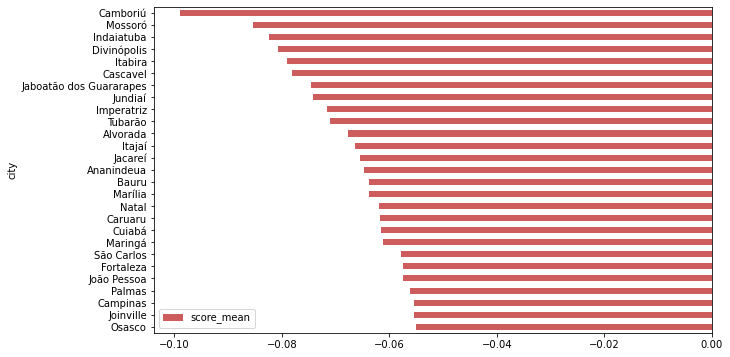

In [31]:
df_cities_neg.sort_values(by=['score_mean'], ascending=False).plot(kind='barh', x='city', y='score_mean', figsize=(10, 6), color=back_color_dados_neg)

Conjunto contendo cidades com as **maiores médias de *scores* de sentimentos**

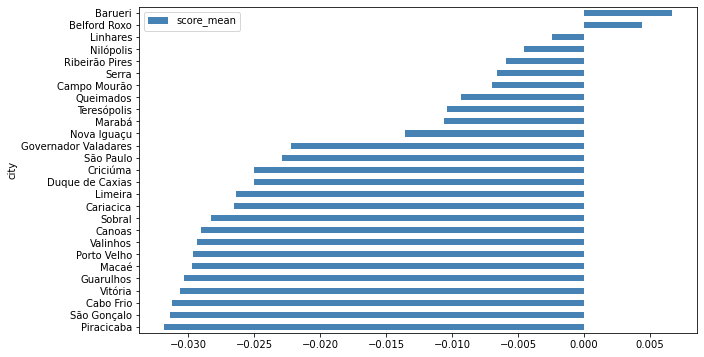

In [32]:
df_cities_pos.sort_values(by=['score_mean'], ascending=True).plot(kind='barh', x='city', y='score_mean', figsize=(10, 6), color=back_color_dados_pos)

***
**Métricas dos conjuntos de cidades**

Métricas das cidades com **menores médias de *scores* de sentimentos**

In [33]:
df_cities_neg['score_mean'].describe()

count    27.000000
mean     -0.067724
std       0.010958
min      -0.098871
25%      -0.074354
50%      -0.064621
75%      -0.059479
max      -0.055026
Name: score_mean, dtype: float64

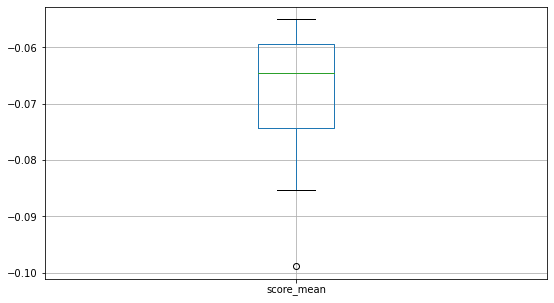

In [34]:
boxplot = df_cities_neg.boxplot(column=['score_mean'], grid=True, figsize=(9, 5))

Métricas das cidades com **maiores médias de *scores* de sentimentos**

In [35]:
df_cities_pos['score_mean'].describe()

count    27.000000
mean     -0.018833
std       0.012216
min      -0.031785
25%      -0.029497
50%      -0.024967
75%      -0.008173
max       0.006627
Name: score_mean, dtype: float64

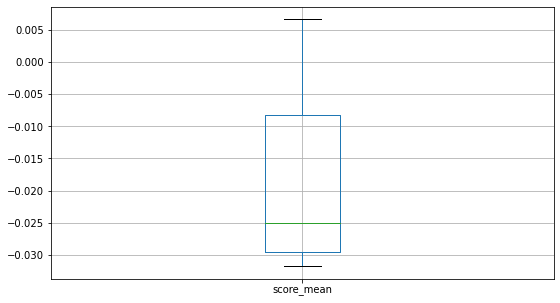

In [36]:
boxplot = df_cities_pos.boxplot(column=['score_mean'], grid=True, figsize=(9, 5))

De acordo com as métricas obtidas acima:
- Os *scores* das 10 cidades com **menores médias** de sentimentos **variam de -0.061920 a -0.054979**, com **média de -0.057929**.
- Os *scores* das 10 cidades com **maiores médias** de sentimentos **variam de -0.031394 a 0.004392**, com **média de -0.023543**.

Observa-se que os dois conjuntos analisados possuem **médias de *scores* de sentimentos negativos e bem próximos a zero**. O que pode ser um indicativo de **neutralidade** em relação aos sentimentos de *tweets* dos conjuntos analisados. 

***
**Médias de sentimentos por período**

Os gráficos abaixo consolidam dados referentes às médias de *scores* de sentimentos para as cidades com menores e maiores médias de *scores* de sentimentos, em cada período analisado.

*Funções auxiliares*

In [37]:
def generate_cities_means_bars(df, title):
    
    bar_width = 0.25

    means_1 = list(df['score_mean_1'])
    means_2 = list(df['score_mean_2'])
    means_3 = list(df['score_mean_3'])

    # Cria eixo x para produto A e produto B com uma separação de 0.25 entre as barras
    x1 =  np.arange(len(means_1))
    x2 = [x + bar_width for x in x1]
    x3 = [x + bar_width for x in x2]

    # Plota as barras
    plt.bar(x1, means_1, width=bar_width, label = 'Antes do 1º caso', color = 'moccasin')
    plt.bar(x2, means_2, width=bar_width, label = 'Após o 1º caso', color = 'sandybrown')
    plt.bar(x3, means_3, width=bar_width, label = 'Após a 1ª morte', color = 'indianred')

    # coloca o nome dos meses como label do eixo x
    cities = list(df['city'])
    plt.xticks([x + bar_width for x in range(len(means_1))], cities)

    # inseri uma legenda no gráfico
    plt.legend()

    plt.title(title)
    plt.xticks(x1, rotation=90)
    plt.xticks(x2, rotation=90)
    plt.xticks(x3, rotation=90)
    plt.show()

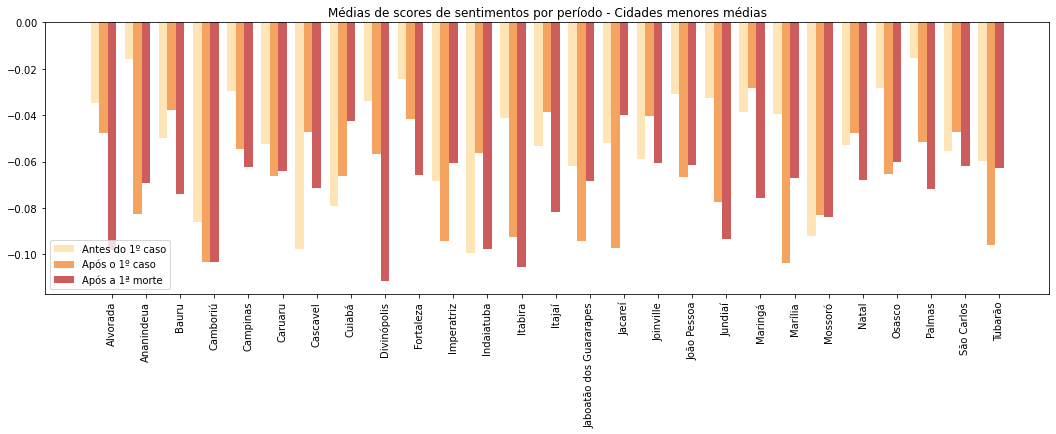

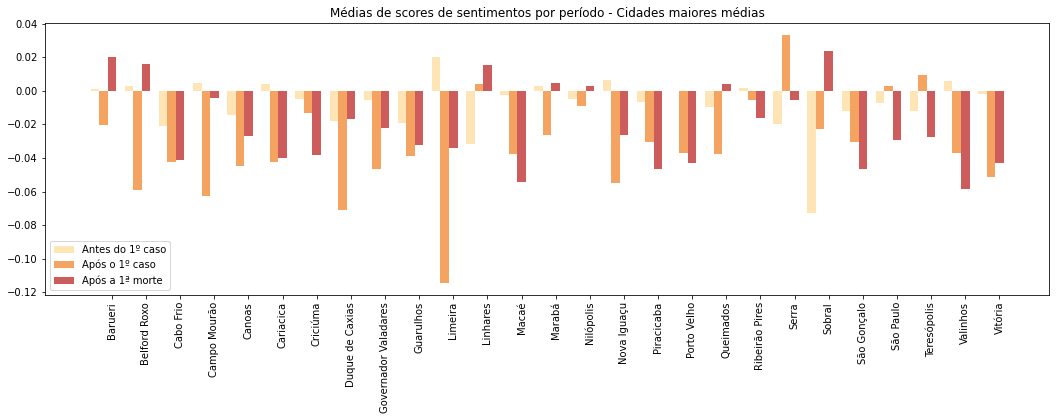

In [64]:
generate_cities_means_bars(df_cities_neg, 'Médias de scores de sentimentos por período - Cidades menores médias')
generate_cities_means_bars(df_cities_pos, 'Médias de scores de sentimentos por período - Cidades maiores médias')

Com base nos gráficos acima, podem ser extraídas as seguintes observações:

- Nas cidades com **menores médias**, os **resultado obtidos nos 3 períodos** analisados são **negativos** em todos os casos;
- Nas cidades com **maiores médias**, algumas delas, apresentam **médias positivas em alguns períodos** e os resultados do **primeiro período** são **melhores** comparados às cidades com menores menores médias.


- Na maioria das cidades com **menores médias** (17 das 27 cidades), os resultados **pioraram entre o segundo e o terceiro período**;
- Também na maioria das cidades com **maiores médias** (22 das 27 cidades), os resultados pioraram na mesma comparação.


- Na maioria das cidades com **menores médias** (17 das 27 cidades), os resultados **pioraram entre o segundo e terceiro período**;
- Já na maioria das cidades com **maiores médias** (16 das 27 cidades) estes resultados **melhoraram**.

A partir dessas observações pode-se questionar: 

- O fato de que as cidades com **maiores médias** apresentaram **resultados melhores no primeiro período** (antes do primeiro caso) pode ser um indicativo de **percepção tardia da população aos efeitos da pandemia**?


- O fato de que **entre o primeiro e o segundo período** houve uma **piora nos dois conjuntos** analisados significa que **ocorreu um alinhamento do comportamento de usuários em relação aos efeitos da pandemia**?


- Considerando que **entre o segundo e o terceiro período**, as cidades com **maiores médias** apresentaram melhora, pode significar uma **melhor reação dos usuários em relação aos efeitos da pandemia do que os usuários das cidades com menores médias**?

***
**Análise da influências negativas e positivas de palavras nos sentimentos dos *tweets***

Para auxiliar na contextualização dos resultados obtidos no passo anterior, esta seção fará uma análise em relação à ocorrência de palavras nas frases que mais influenciaram negativamente ou positivamente nos resultados das médias de *scores* de sentimentos obtidos.

*Funções utilizadas para gerações de gráficos*

In [39]:
max_bars_words = 5
max_clouds_words = 100

back_color_cidades_neg = 'mistyrose'
back_color_cidades_pos = 'aliceblue'

In [40]:
from collections import Counter

In [41]:
def return_tokens_freq(dicts, max_res):
    
    final = Counter({})    
    for tokens_dict in dicts: 
        final = Counter(final) + Counter(tokens_dict)
                
    return dict(final.most_common(max_res))

In [42]:
def generate_bar_from_tokens_freq(dicts, max_res, color, x, y, title):
    
    tokens_freq = return_tokens_freq(dicts, max_res)
    df_words = pd.DataFrame().from_dict(tokens_freq, orient='index', columns=['total'])
    df_words = df_words.sort_values(by = ['total'], ascending=[False])
    df_words = df_words[:max_res]
    df_words.sort_values(by = ['total'], ascending=[True]).plot(kind='barh', figsize=(x, y), color=color, title=title)

In [43]:
def generate_clouds_from_tokens_freq(dicts1, dicts2, max_res, words_color, back_color1, back_color2):
    
    tokens_freq1 = return_tokens_freq(dicts1, max_res)
    wordcloud1 = WordCloud(background_color=back_color1, max_words=100, normalize_plurals=False, color_func=lambda *args, **kwargs: words_color).generate_from_frequencies(tokens_freq1)

    tokens_freq2 = return_tokens_freq(dicts2, max_res)
    wordcloud2 = WordCloud(background_color=back_color2, max_words=100, normalize_plurals=False, color_func=lambda *args, **kwargs: words_color).generate_from_frequencies(tokens_freq2)
    
    fig, (ax1, ax2) = plt.subplots(ncols=2)
    
    ax1.set_facecolor(back_color1)
    ax2.set_facecolor(back_color2)
    
    ax1.imshow(wordcloud1, interpolation='bilinear')    
    ax1.axis("off")
    
    ax2.imshow(wordcloud2, interpolation='bilinear')    
    ax2.axis("off")

In [44]:
def create_df_from_freq(dicts, max_res):
    tokens_freq = return_tokens_freq(dicts, max_res)
    df_words = pd.DataFrame().from_dict(tokens_freq, orient='index', columns=['total'])
    df_words = df_words.sort_values(by = ['total'], ascending=[False])
    df_words = df_words[:max_res]
    df_words = df_words.sort_values(by = ['total'], ascending=[True])  
    return df_words

In [45]:
def generate_cities_bars(dicts1, dicts2, max_res, bar_color, back_color1, back_color2):

    df1 = create_df_from_freq(dicts1, max_res)
    df2 = create_df_from_freq(dicts2, max_res)

    fig, (ax1, ax2) = plt.subplots(ncols=2)
    
    ax1.set_facecolor(back_color1)
    ax2.set_facecolor(back_color2)

    df1.plot(kind='barh', ax=ax1, color=bar_color, title='Cidades com menores médias')
    df2.plot(kind='barh', ax=ax2, color=bar_color, title='Cidades com maiores médias')

    plt.show()

In [46]:
def generate_periods_cities_bars(dicts1, dicts2, dicts3, dicts4, dicts5, dicts6, max_res, bar_color, back_color1, back_color2):

    df1 = create_df_from_freq(dicts1, max_res)
    df2 = create_df_from_freq(dicts2, max_res)
    df3 = create_df_from_freq(dicts3, max_res) 
    
    df4 = create_df_from_freq(dicts4, max_res)
    df5 = create_df_from_freq(dicts5, max_res)
    df6 = create_df_from_freq(dicts6, max_res)

    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
    fig, (ax4, ax5, ax6) = plt.subplots(ncols=3)
    
    ax1.set_facecolor(back_color1)
    ax2.set_facecolor(back_color1)
    ax3.set_facecolor(back_color1)
    
    ax4.set_facecolor(back_color2)
    ax5.set_facecolor(back_color2)
    ax6.set_facecolor(back_color2)

    df1.plot(kind='barh', ax=ax1, color=bar_color, title='Antes do 1º caso')
    df2.plot(kind='barh', ax=ax2, color=bar_color, title='Depois do 1º caso')
    df3.plot(kind='barh', ax=ax3, color=bar_color, title='Após 1ª morte')
    
    df4.plot(kind='barh', ax=ax4, color=bar_color, title='Antes do 1º caso')
    df5.plot(kind='barh', ax=ax5, color=bar_color, title='Depois do 1º caso')
    df6.plot(kind='barh', ax=ax6, color=bar_color, title='Após 1ª morte')

    plt.show()

Palavras presentes nas frases que **mais influenciaram negativamente**

Os passos abaixo exibem gráficos que ajudam a visualização das palavras presentes nas frases que mais influenciaram **negativamente** (destacadas pela cor avermelhada) nos conjuntos de cidades analisados.

As nuvens de palavras abaixo exibem o conjunto de palavras em questão para as cidades com **menores médias** (*backgroud* avermelhado) e cidades com **maiores médias** (*background* azulado). O item seguinte exibe gráficos com as 5 palavras de maior ocorrência nestas nuvens.

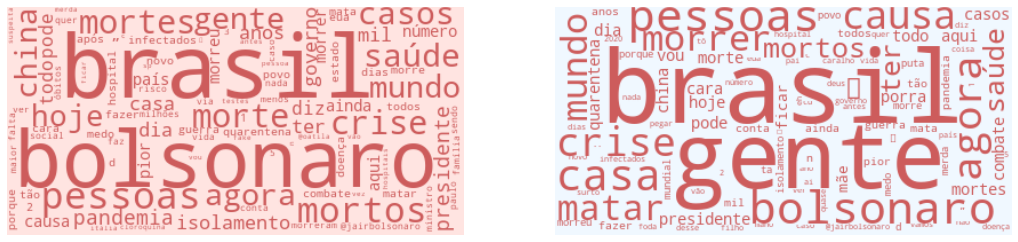

In [63]:
generate_clouds_from_tokens_freq(df_cities_neg['tokens_neg'], df_cities_pos['tokens_neg'], max_clouds_words, back_color_dados_neg, back_color_cidades_neg, back_color_cidades_pos)

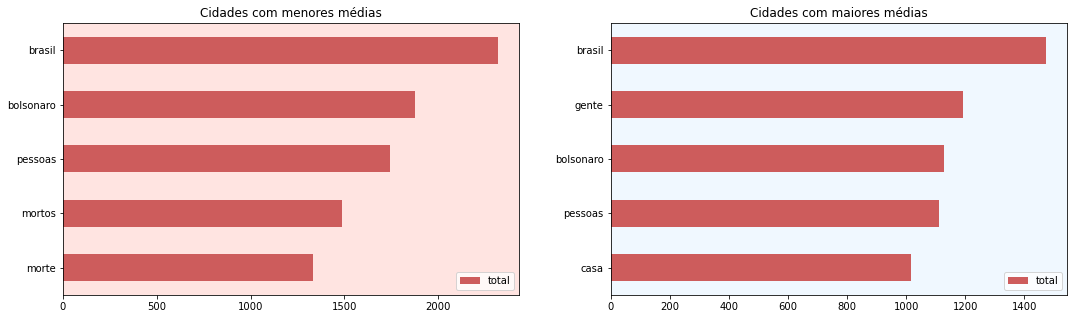

In [62]:
generate_cities_bars(df_cities_neg['tokens_neg'], df_cities_pos['tokens_neg'], max_bars_words, back_color_dados_neg, back_color_cidades_neg, back_color_cidades_pos)

Os gráficos abaixo exibem as 5 palavras de maior ocorrência no conjunto de palavras em questão, nos 3 períodos analisados, para as cidades com menores médias (*background* avermelhado) e maiores médias de sentimentos (*background* azulado).

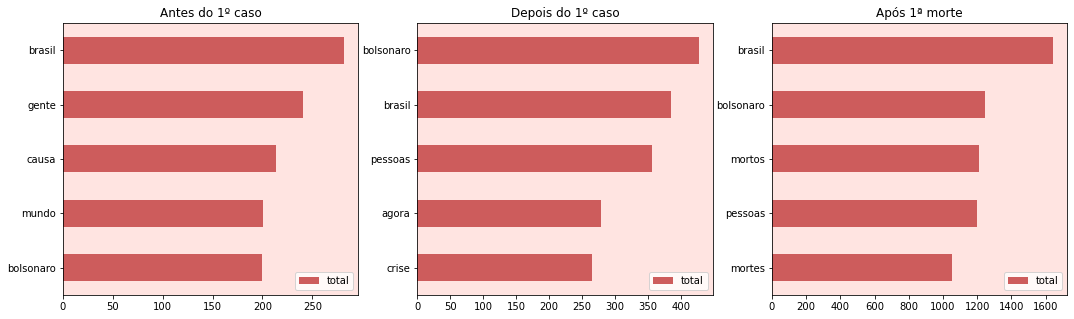

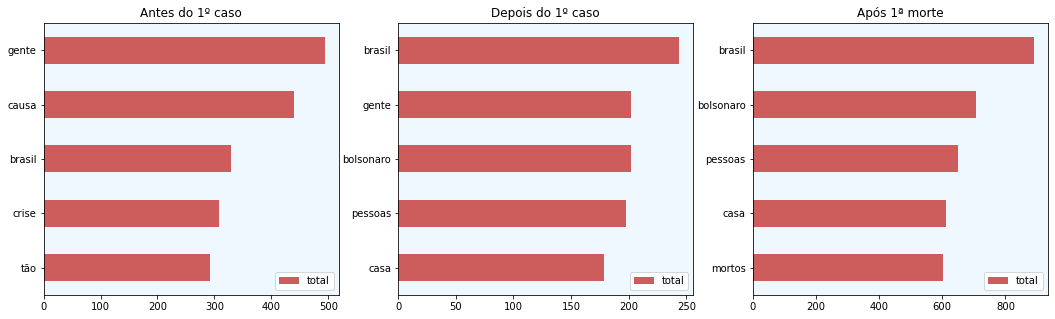

In [61]:
generate_periods_cities_bars(df_cities_neg['tokens_neg_1'], df_cities_neg['tokens_neg_2'], df_cities_neg['tokens_neg_3'], df_cities_pos['tokens_neg_1'], df_cities_pos['tokens_neg_2'], df_cities_pos['tokens_neg_3'], max_bars_words, back_color_dados_neg, back_color_cidades_neg, back_color_cidades_pos)

Palavras presentes nas frases que **mais influenciaram positivamente**

Os passos abaixo exibem gráficos que ajudam a visualização das palavras presentes nas frases que mais influenciaram **positivamente** (destacadas pela cor azulada) nos conjuntos de cidades analisados. O item seguinte exibe gráficos com as 5 palavras de maior ocorrência nestas nuvens.

As nuvens de palavras abaixo exibem o conjunto de palavras em questão para as cidades com **menores médias** (*backgroud* avermelhado) e cidades com **maiores médias** (*background* azulado).

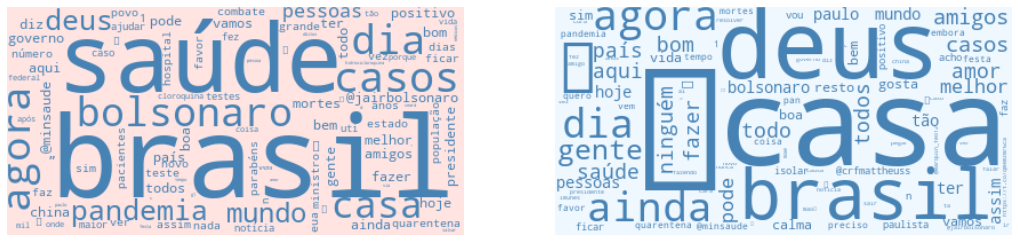

In [60]:
generate_clouds_from_tokens_freq(df_cities_neg['tokens_pos'], df_cities_pos['tokens_pos'], max_clouds_words, back_color_dados_pos, back_color_cidades_neg, back_color_cidades_pos)

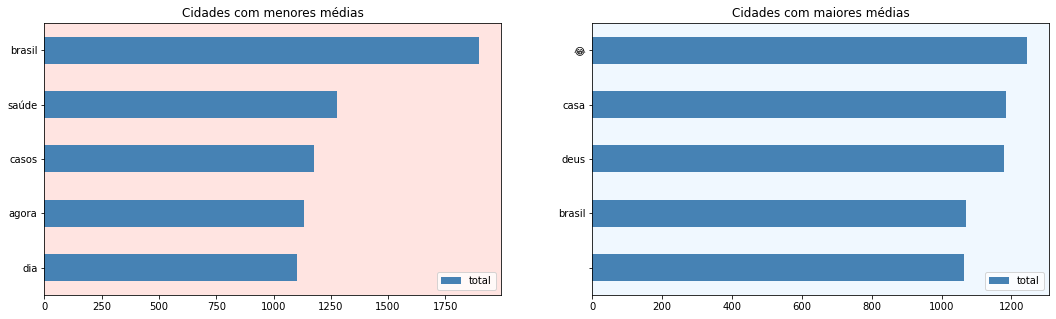

In [59]:
generate_cities_bars(df_cities_neg['tokens_pos'], df_cities_pos['tokens_pos'], max_bars_words, back_color_dados_pos, back_color_cidades_neg, back_color_cidades_pos)

Os gráficos abaixo exibem as 5 palavras de maior ocorrência no conjunto de palavras em questão, nos 3 períodos analisados, para as cidades com menores médias (*background* avermelhado) e maiores médias de sentimentos (*background* azulado).

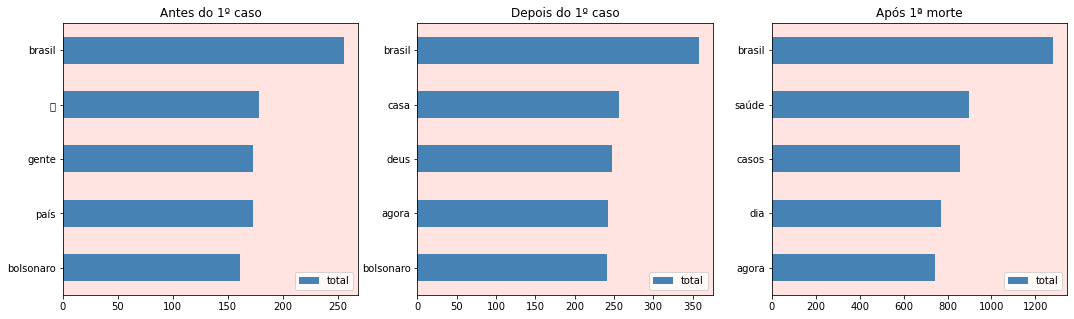

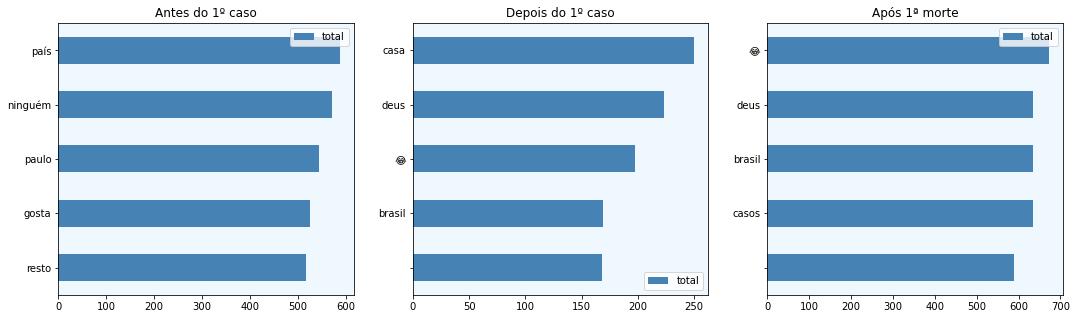

In [58]:
generate_periods_cities_bars(df_cities_neg['tokens_pos_1'], df_cities_neg['tokens_pos_2'], df_cities_neg['tokens_pos_3'], df_cities_pos['tokens_pos_1'], df_cities_pos['tokens_pos_2'], df_cities_pos['tokens_pos_3'], max_bars_words, back_color_dados_pos, back_color_cidades_neg, back_color_cidades_pos)

Com base nos gráficos acima pode-se extrair as seguintes observações:

- A palavra **"bolsonaro"** está presente nos gráficos de influência negativa em ambos os conjuntos de cidades analisados;


- Nas cidades com **maiores médias** a menção ao presidente da república ocorre em menor número e em menor ocorrência, nos recortes analisados;


- Tendo em vista que, no gráfico da seção anterior, os resultados para o **primeiro período** das cidades com **maiores médias** apresenta resultados superiores, observa-se que, neste recorte, a palavra **"bolsonaro" não está presente**;


- No terceiro período (após à primeira morte), nos dois conjuntos de cidades analisados, percebe-se a ocorrência de palavras como **"morte"** e **"mortos"**.

A partir dessas observações pode-se questionar: 

- A grande ocorrência de menções ao presidente da república presentes nas análises acima podem ser um indício de **engajamento político** entre usuários da rede social analisada?


- A ocorrência de **"bolsonaro"** entre os gráficos de influência negativa pode sugerir uma desaprovação ao governo federal? 


- Considerando que **"bolsonaro"** ocorre em **maior quantidade** nos gráficos das cidades com **menores médias** e em **menor quantidade e menor ocorrência** nas cidades com **maiores médias** pode-se sugerir uma **polarização política** nas discussões entre os usuários do Twitter? 


- A mesma afirmação acima pode sugerir que as cidades com maiores médias **não estavam tão engajadas politicamente** em relação às de menores médias?


- Considerando que as **palavras que faziam referência à morte** surgiram nos gráficos de palavras negativas do terceiro período pode-se sugerir que os usuários do Twitter externalizaram um comportamento sensível ao fato de ocorrência da primeira morte por Covid-19 em suas cidades.

***
**Média de *scores* de sentimento por dia das cidades com menores e maiores médias**

Os gráficos a seguir exibem as **médias diárias de *scores* de sentimentos**, para as **cidades com menores e maiores médias**. As linhas verticais vermelhas e preta simbolizam, respectivamente, a data do primeiro caso e a data da primeira morte por Covid-19, em cada cidade.

*Funções utilizadas na geração dos gráficos*

In [53]:
# Função para montar um df de Quantificadores por data a partir do df de Tweets
def building_dates_df(df, date_list, column):

    score_mean_list = []
        
    # Populando quantificadores para cada dia
    for index in date_list:
        
        try:
            # Média de scores do período
            score_mean = mean(df[column].loc[(df['created_at'].dt.year == index.year) & (df['created_at'].dt.month == index.month) & (df['created_at'].dt.day == index.day)])
            score_mean_list.append(score_mean)
        except:
            score_mean_list.append(0)
    
    # Dicionário utilizado como parâmetro para a montagem
    data={'created_at': pd.Series(date_list), column + '_mean':pd.Series(score_mean_list)}
    
    # Criando df
    df = pd.DataFrame(data)
    
    return df 

In [54]:
def generate_cities_means_lines(df, df_cities, title):
    
    df_cities = df_cities.reset_index()
    
    cities = list(df_cities['city'])   
    fig, ax = plt.subplots()
    
    date_list = list(pd.to_datetime(df['created_at']).dt.date.unique())
      
    for index, row in df_cities.iterrows():
        
        df_scores = df.loc[df['city'] == row['city']]
        df_dates = building_dates_df(df_scores, date_list, 'score')   
        
        x = date_list
        y = df_dates.score_mean
        
        first_case_date_str = row['first_case_date']
        first_case_date = datetime.strptime(first_case_date_str, '%Y-%m-%d')
        
        first_death_date_str = row['first_death_date']
        first_death_date = datetime.strptime(first_death_date_str, '%Y-%m-%d')
        
        plt.axvline(first_case_date, color='crimson')
        plt.axvline(first_death_date, color='black')
       
        ax.plot(x, y, linestyle='solid', linewidth=2, label=row['city'])
        
    ax.grid()
    ax.margins(0)

    plt.rcParams['figure.figsize'] = (18,5)
    plt.xticks(x, rotation=90)
    plt.legend(fontsize=15)
    plt.xlabel('Datas',fontsize=15)
    plt.ylabel('Médias',fontsize=15)
    plt.title(title)
    plt.grid(True, linestyle='--')
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0., prop={'size': 10})
    plt.show()

Cidades com **menores médias** de sentimentos

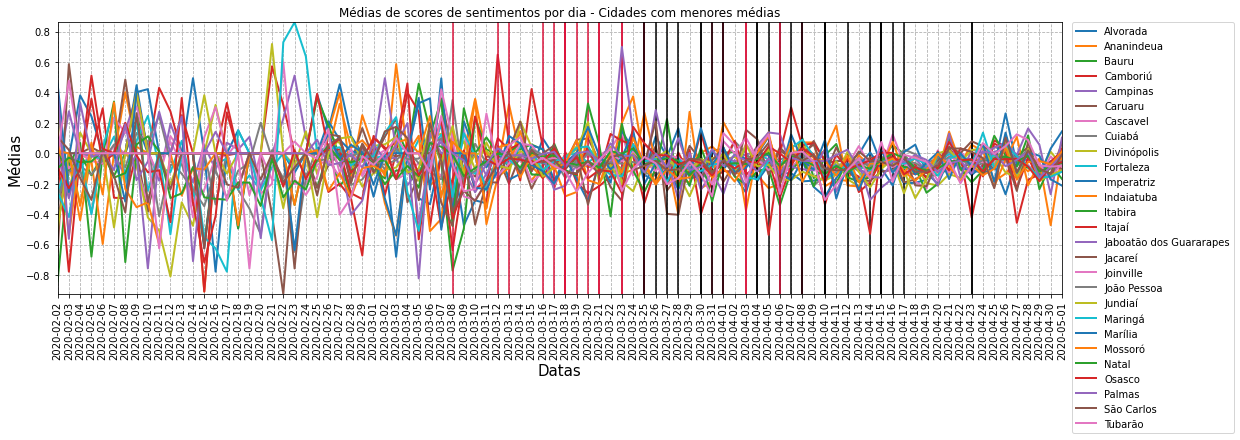

In [57]:
generate_cities_means_lines(df, df_cities_neg, 'Médias de scores de sentimentos por dia - Cidades com menores médias')

Cidades com **maiores médias** de sentimentos

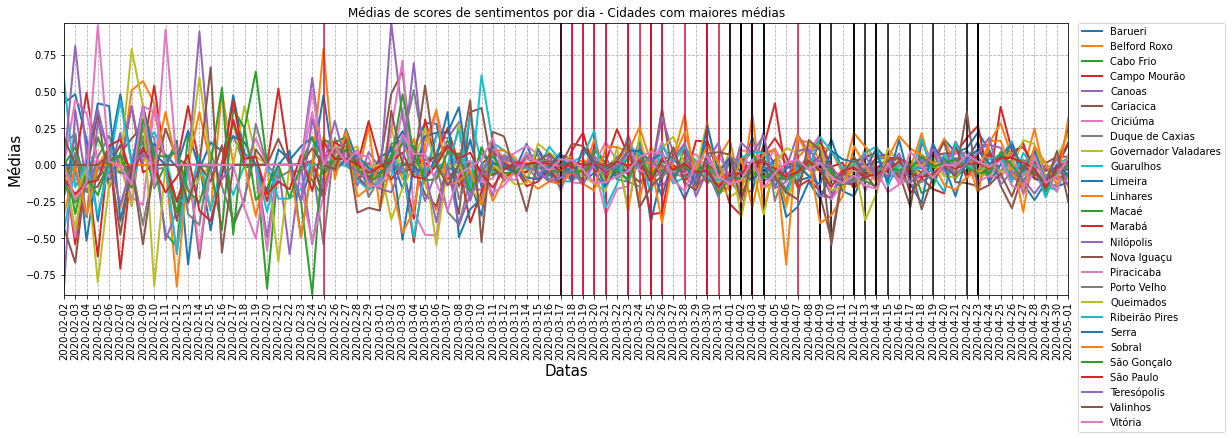

In [56]:
generate_cities_means_lines(df, df_cities_pos, 'Médias de scores de sentimentos por dia - Cidades com maiores médias')

De acordo com os gráficos acima, a **variação das médias diárias dos sentimentos** para cada cidade **diminuiu à medida que os primeiros casos e as primeiras mortes começaram a ocorrer** em cada cidade. 

Com base nesta observação pode-se questionar:

- Pode-se sugerir que houve um alinhamento no discurso de usuários em ambos os conjuntos de cidades?
- Pode-se sugerir que a houve uma acomodação na externalização dos sentimentos dos usuários em reação ao avanço da pandemia?

***
### Resumo

Este *notebook* apresentou uma análise com base nos resultados de sentimentos obtidos na base de dados selecionada na etapa anterior deste trabalho.

A partir de uma **base de dados com Casos de Covid-19 no Brasil**, foram extraídos os intervalos para a definição dos **3 períodos** analisados por este trabalho, para cada cidade, sendo eles: **antes do primeiro caso de Covid-19**, **após o primeiro caso de Covid-19**, **após a primeira morte por Covid-19**.

Com base em métricas estatísticas sobre os resultados dos *scores* de sentimentos foram criados **conjuntos** contendo as cidades com **menores e maiores médias de *scores* de sentimentos**. 

A partir destes conjuntos foram gerados gráficos com a finalidade de se observar **padrões comportamentais dos usuários**, a partir dos **sentimentos resultantes dos 3 períodos analisados**.

Por fim, este trabalho lista uma série de **observações extraídas destes resultados** e sugere **questionamentos relacionados às reações dos usuários em relação em relação à pandemia da Covid-19 no Brasil**.

***
### Fontes

(1) VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text

(2) Brasil.io - Boletins informativos e casos do coronavírus por município por dia -https://brasil.io/dataset/covid19/caso_full/